## Food Delivery Duration Prediction

In [1]:
__author__ = "Jiting Jiang"
__email__ = "jiting.jiang@outlook.com"
__website__ = "https://jitingjiang.github.io/minimal-portfolio/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno

In [3]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

### Part 1 - Introduction

#### Project Overview

In this project, I am going to use a subset of food deliveries received at DoorDash in early 2015 in a subset of the cities (provided by DoorDash).

I will build Machine Learning (ML) algorithms (such as Linear Regression, LASSO, and Random Forest) to predict the expected time of food delivery duration. 

The ML prediction analysis covers the complete workflow steps from (1) data preparation, (2) explanatory descriptive analysis, (3) feature engineering, and (4) classical machine learning. 

It is primarily Python-based and uses multiple libraries, including numpy, pandas, matplotlib, seaborn, and sklearn. 

#### Problem Background

For companies like DoorDash, it is essential for them to present a good approximation of the expected time of food delivery based on the initial order placement time to improve consumer experience and company development. 

On the one hand, consumers tend to expect the food to be delivered on time as promised. If not, they may feel disappointed, leave negative reviews and even turn to other similar services. 

On the other hand, predicting an accurate delivery time can help the company to achieve optimal operational efficiencies, such as scheduling drivers, managing orders, and forecasting demand. These can be crucial in reducing costs and maintaining a good company reputation.

#### Dataset Information

The dataset is presented in a .csv file, where each row shows one unique delivery and each column presents different kinds of features related to the delivery. 

In [4]:
ddp = pd.read_csv('historical_data.csv')
ddp.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


The raw dataset has about 200,000 delivery records and 16 features. 

The delivery-associated features can be roughly grouped into four: (1) time features, (2) store features, (3) order features, and (4) market features. They are not all numeric, and I will check if the data types make sense. 

In [5]:
ddp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

### Part 2 - Discover

#### Data Cleaning

First, Let's check if the feature names and data types make sense. 

In [6]:
ddp.rename(columns={'subtotal':'total_price'}, inplace=True)

In [7]:
# set datetime data types
ddp['created_at'] = pd.to_datetime(ddp['created_at'])
ddp['actual_delivery_time'] = pd.to_datetime(ddp['actual_delivery_time'])

# set string data types
ddp['market_id'] = ddp['market_id'].astype('str')
ddp['store_id'] = ddp['store_id'].astype('str')

# set categorical data types
ddp['order_protocol'] = ddp['order_protocol'].astype('str')

Second, since most of the ML models work better with non-missing data, I will check the missingness (as well as duplicates just for completion). 

Specifically, I follow the two steps: 
* check on non-standard missing values and convert to 'NaN' (np.nan)
* visualize missingness patterns via heatmap

In [8]:
for col in ddp.columns:
    print(ddp.value_counts(col))
    
ddp = ddp.replace(["nan","n/a", "na", "-", "--", "?"], np.nan)

market_id
2.0    55058
4.0    47599
1.0    38037
3.0    23297
5.0    18000
6.0    14450
nan      987
dtype: int64
created_at
2015-01-24 01:56:33    6
2015-02-11 19:50:43    6
2015-02-11 19:51:06    5
2015-02-16 01:48:11    5
2015-02-08 02:20:03    5
                      ..
2015-01-31 23:01:28    1
2015-01-31 23:01:45    1
2015-01-31 23:01:53    1
2015-01-31 23:02:37    1
2015-02-18 06:00:44    1
Length: 180985, dtype: int64
actual_delivery_time
2015-02-08 04:09:25    5
2015-01-24 03:41:03    5
2015-02-05 03:10:31    5
2015-02-11 20:40:45    5
2015-02-16 03:51:49    5
                      ..
2015-02-01 00:52:45    1
2015-02-01 00:52:50    1
2015-02-01 00:52:55    1
2015-02-01 00:52:56    1
2015-02-19 22:45:31    1
Length: 178110, dtype: int64
store_id
6865    937
1311    863
314     815
1686    765
3937    721
       ... 
3836      1
1600      1
5242      1
1598      1
4033      1
Length: 6743, dtype: int64
store_primary_category
american             19399
pizza                17321
m

<AxesSubplot:>

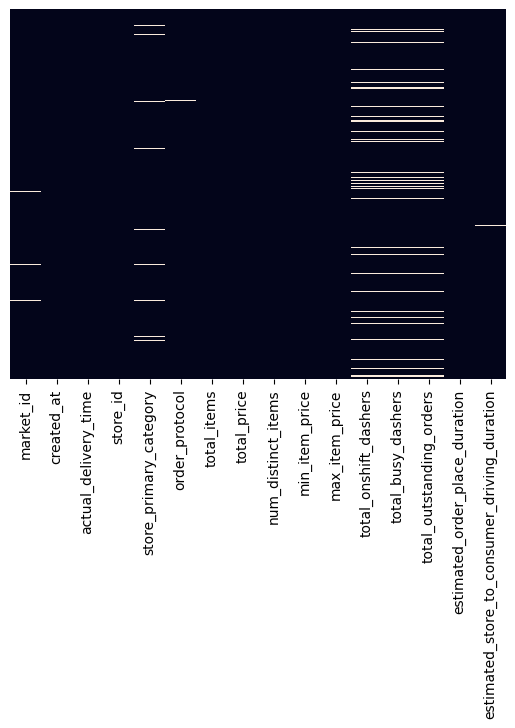

In [9]:
sns.heatmap(data=ddp.isnull(), yticklabels=False, cbar=False)

The heatmap above shows that 'total_onshift_dashers' & 'total_busy_dashers' & and 'total_outstanding_orders' have the most missingness (accounting for about 8%), while the other features have only a few missingness (about 2% or less). 

I later drop these records with missing values, since they are of relatively small share compared to the total number of records.

Besides, there do not seem to be duplicated rows in the dataset. 

In [10]:
duplicate_rows = ddp.duplicated().sum()
duplicate_rows

0

In [11]:
# drop records with missing values
cols_to_drop = ddp.columns[ddp.isnull().any()]
ddp = ddp.dropna(subset=cols_to_drop)

# check if there are no missing values in all features 
ddp.isnull().sum().sort_values()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
total_price                                     0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

I also check the data validation for certain features. 

* I expect the 'total number of items in the order' to be larger than 'the number of distinct items included in the order.' 

* 'The number of available dashers currently working on an order within 10 miles of the store at the time of order creation' should also be a subset of 'the number of available dashers nearby.' 

From below, it is surprising to see that a nontrivial number of records having 'total_busy_dashers', greater than, 'total_onshift_dashers.' I leave it as it is for now, but do consider this as a data issue.

In [12]:
bool1 = ddp['total_items'] >= ddp['num_distinct_items']
count_of_false = sum(map(lambda x: 1 if x==False else 0, bool1))
print(count_of_false)

bool2 = ddp['total_onshift_dashers'] >= ddp['total_busy_dashers']
count_of_false = sum(map(lambda x: 1 if x==False else 0, bool2))
print(count_of_false)

0
39290


#### Identify Target and Feature Variables

I create the target variable 'delivery_duration' by subtracting the order placed timestamp 'created_at' from the actual delivery timestamp 'actual_delivery_time.' 

For feature variables, I drop not only those redundant or less relevant to the target variable based on the context, but also create new features that might be useful for predicting the food delivery duration.

In [13]:
# create the target variable
ddp1 = ddp.copy()

ddp1['delivery_duration'] = (ddp1['actual_delivery_time']-ddp1['created_at']).dt.total_seconds()
ddp1['delivery_duration'].head()

0     3779.0
1     4024.0
8     1586.0
14    2273.0
15    2988.0
Name: delivery_duration, dtype: float64

In [14]:
# create a new feature named 'busy_dashers_ratio'
ddp1["busy_dashers_ratio"] = ddp1['total_busy_dashers'] / ddp1['total_onshift_dashers']
print(ddp1["busy_dashers_ratio"].head())

# drop the remaining missingness in 'busy_dashers_ratio'
ddp1.replace([np.inf, -np.inf], np.nan, inplace=True)
ddp1 = ddp1.dropna(subset=['busy_dashers_ratio'])

0     0.424242
1     2.000000
8     0.750000
14    1.200000
15    1.000000
Name: busy_dashers_ratio, dtype: float64


In [15]:
ddp1.drop(['store_id', 'min_item_price', 'max_item_price', 'total_outstanding_orders'], axis=1, inplace=True)
ddp1.drop(['actual_delivery_time','created_at', 'total_busy_dashers', 'total_onshift_dashers'], axis = 1, inplace = True)

#### Exploratory Data Analysis

There are a lot of aspects that can be checked with EDA. Despite its importance, I will keep it concise since the project's primary goal is to predict food delivery duration. 

To be concrete, I will mainly use EDA to achieve the following two things.
* identify feature outliers and correct them if necessary
* check the bivariate relationship between features with a focus on the target variable

To perform EDA, a good practice for the first step is to store numeric and categorical features separately, since they typically involve using different visualization plot types.

In [16]:
cat_columns = ddp1.select_dtypes(include=['object']).columns
print(cat_columns)

num_columns = ddp1.select_dtypes(include=['int64', 'float64']).columns
print(num_columns)

Index(['market_id', 'store_primary_category', 'order_protocol'], dtype='object')
Index(['total_items', 'total_price', 'num_distinct_items',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration',
       'busy_dashers_ratio'],
      dtype='object')


I start with the categorical features by looking at the distinct values and their frequencies.
* For 'market_id' and'order_protocol,' there are a small set of distinct values, so I can directly plot them altogether. 
* For 'store_primary_category,' too many unique values are present. So I first identify the top five store types in terms of popularity, which are ‘american’, ‘pizza’, ‘mexican’, ‘burger’, and ‘sandwich.’ I then focus on these five store types and group the rest into the 'other' category. 

(Note, one may clean and bin the store categories. For now, I just use the data as presented in the data.)

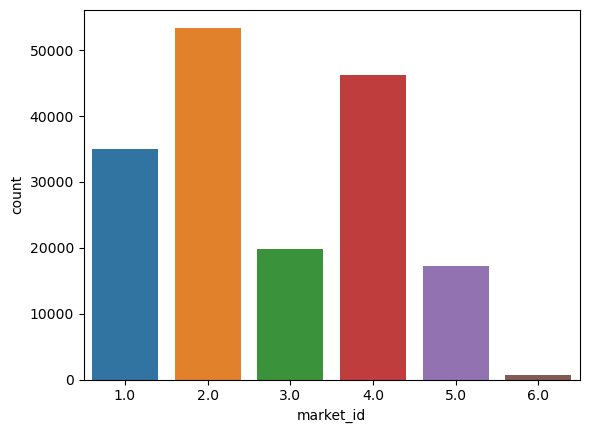

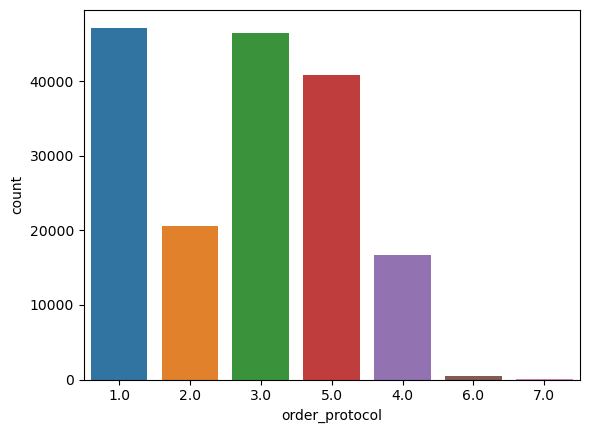

In [17]:
cat_columns_1 = ['market_id', 'order_protocol']

for col in cat_columns_1:
    sns.countplot(x=col, data=ddp1)
    plt.show()

store_primary_category
american    17869
pizza       15495
mexican     15430
burger       9734
sandwich     8862
dtype: int64


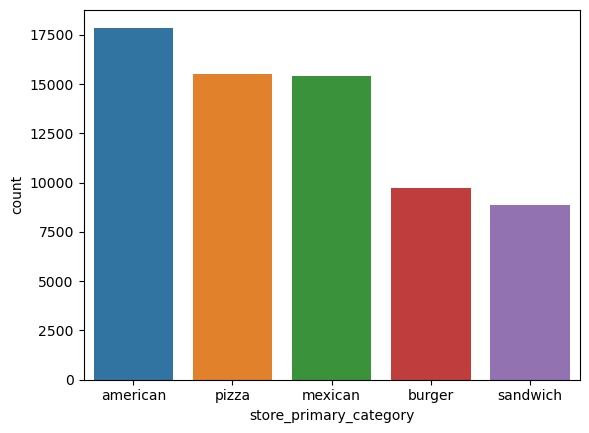

In [18]:
# identify the top 5 popular values for 'store_primary_category'
store_value_high = ddp1.value_counts('store_primary_category').head(5)
print(store_value_high)
sns.countplot(x='store_primary_category', data=ddp1, 
              order=['american', 'pizza', 'mexican', 'burger', 'sandwich'])

# assign the rest 'store_primary_category' values into a new category as 'other'
def group_categories(x):
    if x in store_value_high:
        return x
    else:
        return 'other'

ddp2 = ddp1.copy()
ddp2['store_primary_category'] = ddp2['store_primary_category'].apply(group_categories)

Then I examine the numeric features by looking at the summary statistics and visualizing their distributions.

According to the patterns shown in the summary statistics table and boxplots below, there are some evidences of outliers in these numeric features. I choose to drop the outliers based on the interquartile range. I then recheck if the distributions look better after correction.

In [19]:
ddp2.describe()

,total_items,total_price,num_distinct_items,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,busy_dashers_ratio
count,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000
mean,3.202043,2700.330256,2.672926,307.356557,546.077945,2854.014950,0.950529
std,2.676019,1828.425491,1.622634,89.603143,218.565924,1401.718847,0.405718
min,1.000000,0.000000,1.000000,0.000000,0.000000,101.000000,-13.000000
25%,2.000000,1419.000000,1.000000,251.000000,384.000000,2101.000000,0.827957
50%,3.000000,2227.000000,2.000000,251.000000,544.000000,2655.000000,0.962963
75%,4.000000,3420.000000,3.000000,446.000000,703.000000,3371.000000,1.000000
max,411.000000,26800.000000,20.000000,2715.000000,2088.000000,332482.000000,31.000000


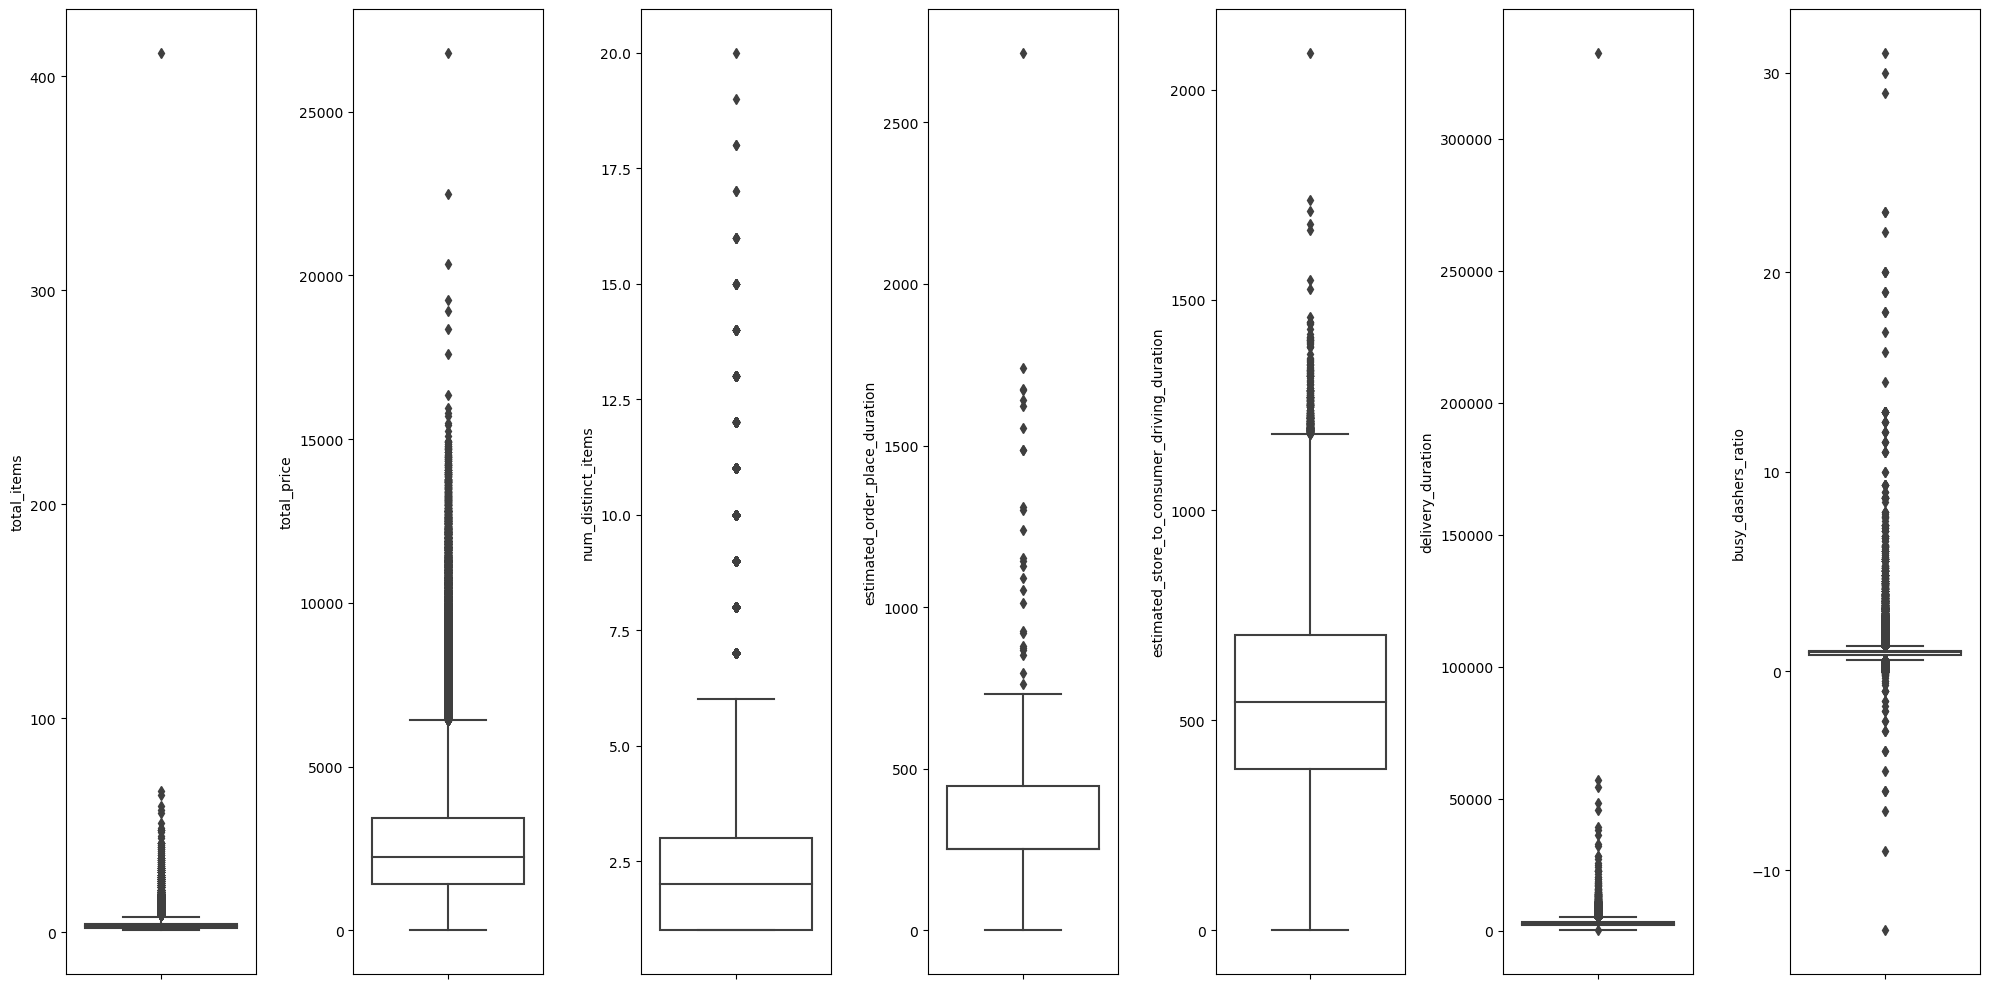

In [20]:
# visualize continuous features distributions in boxplots
def numeric_eda_box(df, hue=None):
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()
    
numeric_eda_box(ddp2)

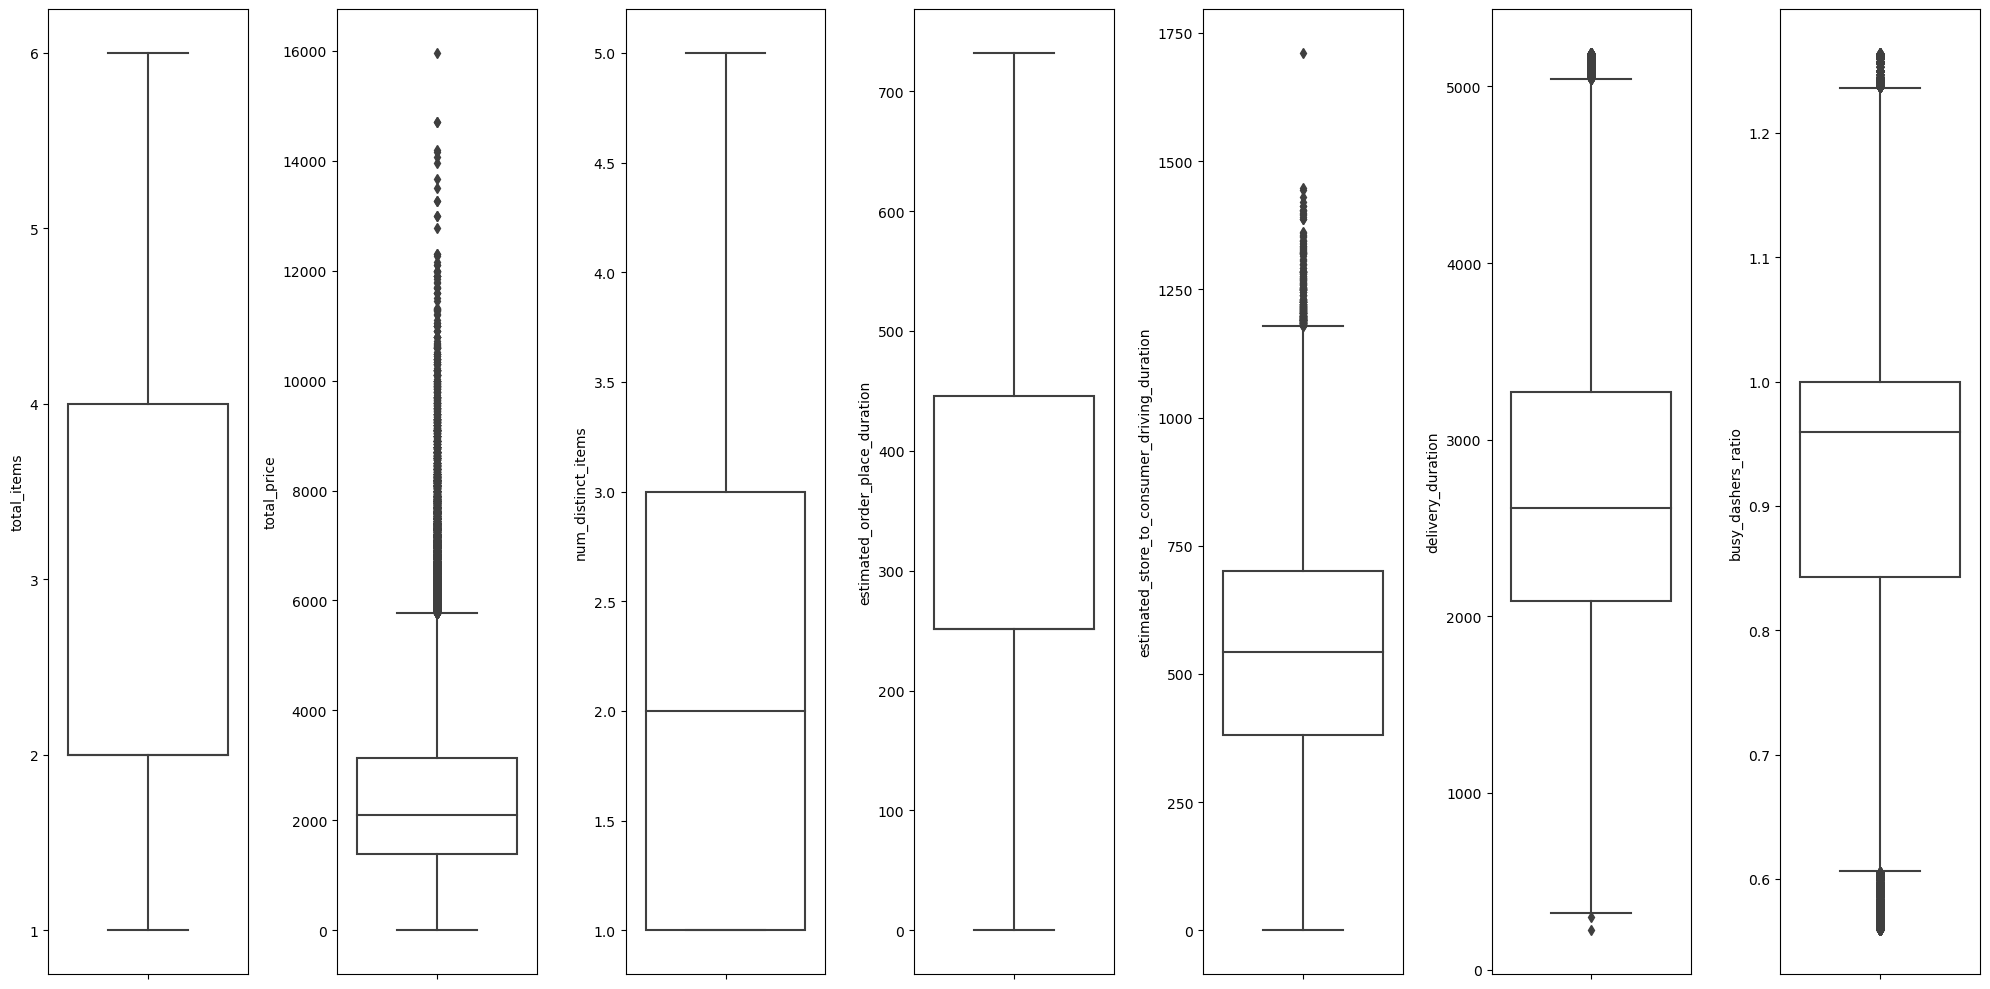

In [21]:
# drop outliers based on iqr 
for col in ['total_items', 'num_distinct_items', 'estimated_order_place_duration','delivery_duration', 'busy_dashers_ratio']:
    
    q75 = ddp2[col].quantile(0.75)
    q25 = ddp2[col].quantile(0.25)
    
    intr_qr = q75 - q25
    
    upper = q75 + (1.5*intr_qr)
    lower = q25 - (1.5*intr_qr)

    ddp2 = ddp2[(ddp2[col] > lower) & (ddp2[col] < upper)]
    
numeric_eda_box(ddp2)

According to the cleaned sample, the actual delivery duration has a mean of 45 minutes and a standard deviation of 14 minutes. The minimum and maximum actual delivery duration equal 5 minutes and 86 minutes, respectively. 

On average, each delivery tends to order 2.6 total items and about 2.4 are unique. The mean total order expense is around 25 dollars.  

In [22]:
ddp2.describe()

,total_items,total_price,num_distinct_items,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,busy_dashers_ratio
count,134067.000000,134067.000000,134067.000000,134067.000000,134067.000000,134067.000000,134067.000000
mean,2.648534,2430.656493,2.350817,306.252113,543.623755,2727.963377,0.924611
std,1.350154,1414.813247,1.151454,88.273515,218.068440,865.251369,0.138208
min,1.000000,0.000000,1.000000,0.000000,0.000000,223.000000,0.558824
25%,2.000000,1387.500000,1.000000,251.000000,381.000000,2087.000000,0.842593
50%,2.000000,2104.000000,2.000000,251.000000,542.000000,2616.000000,0.959184
75%,4.000000,3140.000000,3.000000,446.000000,700.000000,3269.000000,1.000000
max,6.000000,15960.000000,5.000000,732.000000,1711.000000,5190.000000,1.264151


After checking the univariate distribution for both numeric and categorical features, I move on to examine the bivariate relationships between features, focusing on the target feature. 

Like before, I separate this part of the analysis into two and present using visualization.
* the relationship between the target and (selected) categorical features
* the relationship between target and numeric features

<AxesSubplot:xlabel='delivery_duration', ylabel='Density'>

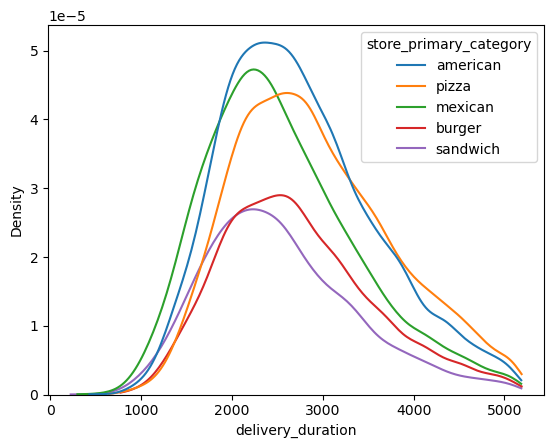

In [23]:
top_five = ['american', 'pizza', 'mexican', 'burger', 'sandwich']

sns.kdeplot(data=ddp2, x='delivery_duration', hue='store_primary_category', 
            hue_order=top_five, cut=0)

For the listed five popular store food types, on average, ‘sandwich’ (shown in purple) and ‘mexican’ food type (shown in green) take shorter delivery durations than the other three common ordered food types.

<AxesSubplot:>

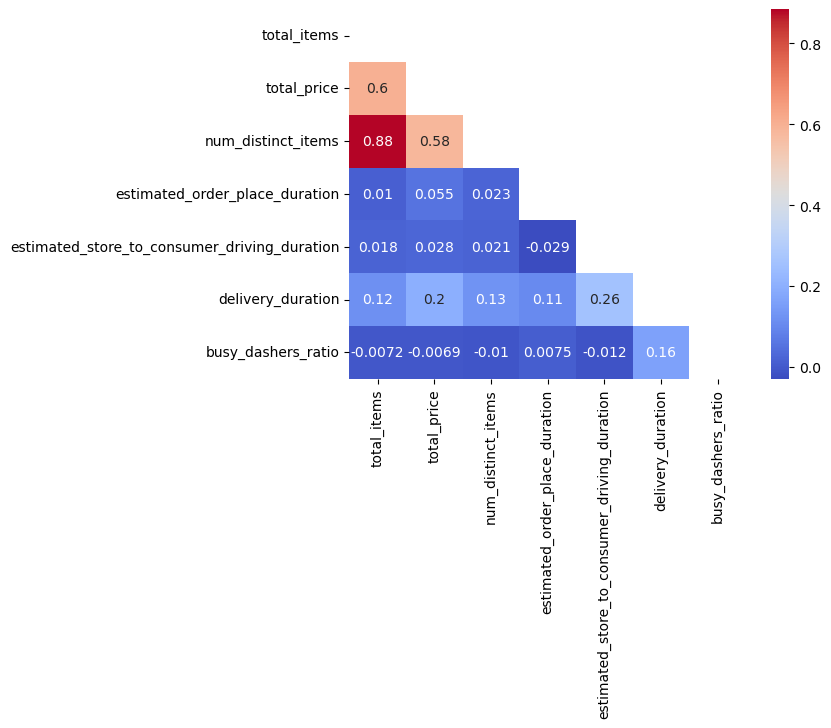

In [24]:
corr = ddp2.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(data=corr, annot=True, cmap='coolwarm', mask=mask)

There seem to be strong positive correlations between the total price, the total number of items and the number of distinct items in a delivery order, which makes sense. 

Focusing on the target feature, the correlation matrix shows that the delivery time tends to be longer if the store and consumer is further apart, or the food takes more time to prepare (likely reflected in higher total order expense and the number of (distinct) food items). 

#### Feature Engineering

In this part, I will first encode categorical features into dummies, and then perform feature selection using three distinct approaches.

Feature selection is very important for ML prediction, since models tend to overfit badly on high-dimensional data. I use the following three distinct approaches:
* drop features with no or little variation
* drop highly correlated features (since they tend to contain the almost same information)
* drop features that contribute less to the model performance (using the tree-based feature selection method)

In [25]:
# encode categorical features into dummies
print(ddp2.shape)

ddp3 = ddp2.copy()

# for market_id
market_id_dummies = pd.get_dummies(ddp3.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')

# for store_primary_category
store_primary_category_dummies = pd.get_dummies(ddp3.store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')

# for order_protocol
order_protocol_dummies = pd.get_dummies(ddp3.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('protocol_')

# concatenate the generated dummy variables
ddp3 = pd.concat([ddp3, market_id_dummies, 
                store_primary_category_dummies, order_protocol_dummies], axis = 1)

# drop redundant features
ddp3 = ddp3.drop(columns = ['market_id', 'store_primary_category', 
                           'order_protocol'])

ddp3.head()

(134067, 10)


,total_items,total_price,num_distinct_items,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,busy_dashers_ratio,market_id_1.0,market_id_2.0,market_id_3.0,...,category_other,category_pizza,category_sandwich,protocol_1.0,protocol_2.0,protocol_3.0,protocol_4.0,protocol_5.0,protocol_6.0,protocol_7.0
8,4,4771,3,446,289.0,1586.0,0.750000,0,1,0,...,1,0,0,0,0,1,0,0,0,0
14,1,1525,1,446,795.0,2273.0,1.200000,1,0,0,...,1,0,0,1,0,0,0,0,0,0
15,2,3620,2,446,205.0,2988.0,1.000000,1,0,0,...,1,0,0,1,0,0,0,0,0,0
17,3,4375,3,446,789.0,4976.0,0.666667,1,0,0,...,1,0,0,1,0,0,0,0,0,0
19,2,950,2,446,212.0,3019.0,1.000000,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [26]:
# drop features with little variance
varthr = VarianceThreshold(threshold=0.01)
varthr.fit(ddp3)

mask = varthr.get_support()
ddp4 = ddp3.loc[:, mask]

print(ddp4.shape)

(134067, 23)


In [27]:
# drop features that are highly correlated
corr1 = ddp4.corr().abs()

mask1 = np.triu(np.ones_like(corr1, dtype=bool))
tri_df = corr1.mask(mask1)

to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.85)]
to_drop 

ddp4 = ddp4.drop(to_drop, axis=1)
ddp4.shape

(134067, 21)

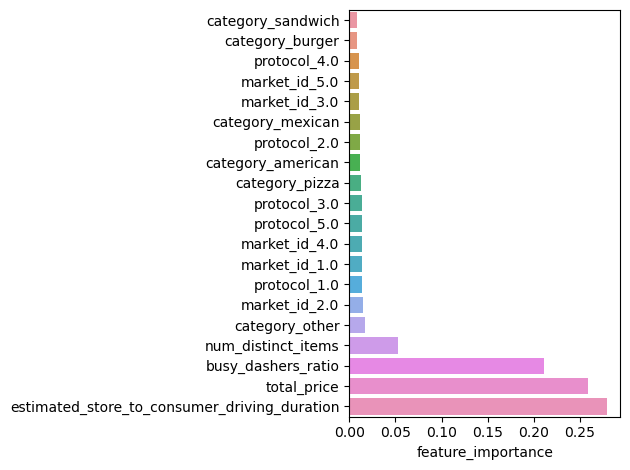

In [28]:
# select features based on model performance (using random forest)

# split data into train and test
from sklearn.model_selection import train_test_split

X_toselect = ddp4.drop(['delivery_duration'], axis=1)
y_toselect = ddp4['delivery_duration']

X_toselect_train, X_toselect_test, y_toselect_train, y_toselect_test = train_test_split(
    X_toselect, y_toselect, test_size=0.2, random_state=42)

# use tree-based feature selection
rf = RandomForestRegressor(random_state=42)
rf.fit(X_toselect_train, y_toselect_train)

# visualize feature importance
importances = dict(zip(X_toselect_train.columns, rf.feature_importances_))
importances_df = pd.DataFrame.from_dict(importances, orient='index').rename(columns={0: 'feature_importance'}).sort_values(by='feature_importance')

sns.barplot(data=importances_df, 
            x='feature_importance', 
            y=importances_df.index)
plt.tight_layout()
plt.savefig('feature_importance.png')

In summary, the number of features equals 10 before feature engineering and equals 26 after transforming categorical features into dummies. 

Each of the three feature selection steps reduces feature numbers by 3 (to 23), 2 (to 21), and 17 (to 4). 

From the random forest (RF) feature importance figure, four features are standing out. 
* estimated _store_to_consumer_driving_duration
* total_price
* busy_dashers_ratio
* num_distrinct_items

These all make perfect sense since one would expect the delivery time to be longer if the food takes more time to prepare (likely reflected in higher total order expense as well as the different food items), if there is less dasher around (and maybe take longer time to assign a dasher to the order and for the dasher to pick up the order), and if the store and consumer is further apart. 

#### Prepare Data for ML

According to the feature engineering results, I compile the final data for ML by going through the following steps:
* keep only selected features in the final dataset
* redefine features and target variables
* split the data into train and test set
* standardize the feature data

In [29]:
ddp5 = ddp4[['delivery_duration', 'estimated_store_to_consumer_driving_duration', 'total_price', 'busy_dashers_ratio', 'num_distinct_items']]

In [30]:
X = ddp5.drop(['delivery_duration'],axis=1)
y = ddp5['delivery_duration']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [32]:
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Part 3 - Create Model

I perform the linear regression model and cross-validated LASSO and report their performance in R-squared and RMSE (Root Mean Squared Error). 

I also check the model mean predictions and model coefficients to see if the signs make sense.

In [33]:
# train the linear regression model
lm = linear_model.LinearRegression()
lm.fit(scaled_X_train,y_train)

# evaluate the model performance
print("Accuracy on training set: {:.3f}".format(lm.score(scaled_X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(lm.score(scaled_X_test,y_test)), '\n')
print('RMSE on training set:', np.sqrt(metrics.mean_squared_error(y_train, lm.predict(scaled_X_train))))
print('RMSE on test set:', np.sqrt(metrics.mean_squared_error(y_test, lm.predict(scaled_X_test))), '\n')

# model prediction
print("Mean outcome prediction on training set: {:.3f}".format(lm.predict(scaled_X_train).mean()))
print("Mean outcome prediction on test set: {:.3f}".format(lm.predict(scaled_X_test).mean()))

# look at the coefficients
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

Accuracy on training set: 0.129
Accuracy on test set: 0.135 

RMSE on training set: 805.5029292835128
RMSE on test set: 812.4306184832839 

Mean outcome prediction on training set: 2724.963
Mean outcome prediction on test set: 2722.518
                                              Coefficient
estimated_store_to_consumer_driving_duration   219.505072
total_price                                    155.317128
busy_dashers_ratio                             141.057146
num_distinct_items                              15.287505


The linear regression using the small feature set obtains an R-squared equaling 0.135 and a Root mean squared error of 812.43 on the test set. 

The mean predicted delivery duration is about 2723 seconds (i.e., 45 minutes). The coefficient signs are all positive and seem logical.

In [34]:
# Do cross-validated Lasso  
X1 = ddp4.drop(['delivery_duration'],axis=1)
y1 = ddp4['delivery_duration']

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42)

scaler = StandardScaler()

scaled_X1_train = scaler.fit_transform(X1_train)
scaled_X1_test = scaler.transform(X1_test)

lassocv=linear_model.LassoCV(random_state=42).fit(scaled_X1_train,y1_train)

# print out the chosen value for alpha
print("Chosen alpha: {:.3f}".format(lassocv.alpha_))
# print the original number of regressors and the number selected by lasso
print("Number of regressors in the menu: ",len(X1.columns))
print("Number of regressors selected by lasso: ",sum(lassocv.coef_!=0), '\n')

# evaluate the model performance
print("Accuracy on training set: {:.3f}".format(lassocv.score(scaled_X1_train,y1_train)))
print("Accuracy on test set: {:.3f}".format(lassocv.score(scaled_X1_test,y1_test)), '\n')
print('RMSE on training set:', np.sqrt(metrics.mean_squared_error(y1_train, lassocv.predict(scaled_X1_train))))
print('RMSE on test set:', np.sqrt(metrics.mean_squared_error(y1_test, lassocv.predict(scaled_X1_test))), '\n')

# print lasso predictions
print("Mean outcome prediction on training set: {:.3f}".format(lassocv.predict(scaled_X1_train).mean()))
print("Mean outcome prediction on test set: {:.3f}".format(lassocv.predict(scaled_X1_test).mean()))

# look at the coefficients
results = pd.DataFrame({'feature': X1.columns[lassocv.coef_!=0],'coefficient': lassocv.coef_[lassocv.coef_!=0]})
results

Chosen alpha: 0.223
Number of regressors in the menu:  20
Number of regressors selected by lasso:  19 

Accuracy on training set: 0.149
Accuracy on test set: 0.159 

RMSE on training set: 796.2822277180832
RMSE on test set: 800.8422062669653 

Mean outcome prediction on training set: 2724.963
Mean outcome prediction on test set: 2722.481


,feature,coefficient
0,total_price,149.435054
1,num_distinct_items,17.755964
2,estimated_store_to_consumer_driving_duration,224.002503
3,busy_dashers_ratio,141.820695
4,market_id_1.0,13.477032
5,market_id_2.0,-32.930532
6,market_id_3.0,-23.234011
7,market_id_4.0,7.337094
8,market_id_5.0,7.424505
9,category_american,-3.489107


LASSO (combined with cross-validation) based on the dataset with 21 features (without performing random forest) ends up using most of the features. 

It obtains R-squared equaling 0.159, Root mean squared error of 800.84, as well as mean predicted delivery duration of 2722 seconds (i.e., 45 minutes) on the test set.

### Part 4 - Conclusion

In the first two parts of the project, I reviewed the dataset used for predicting food delivery duration. I also cleaned the data, identified target and feature variables, and ran exploratory data analysis. 

Besides, I did feature engineering by first encoding categorical features into dummies, and then performing feature selection using three distinct approaches involving the random forest method. The feature importance from RF shows that only four features matter the most for the prediction. 

Finally, I perform two commonly used ML models, which are the linear regression on the small feature set and cross-validated LASSO on a larger feature set.

Comparing the two models, they are pretty similar in terms of model performance, both generating RMSE of around 800 and mean prediction value of 45 minutes. The linear regression model would be my preferred model given its simplicity.

#### Final thoughts

Overall, this project has quite an interesting and practical business setup. I am curious to find out what features matter more for predicting food delivery duration and to apply ML models for prediction. The raw dataset containing missing values and outliers also allows me to practice my data cleaning and explanatory data analysis skills. 

I hope you enjoy this project. If you have any questions, please feel free to contact me. Thanks for reading!